In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree

df = pd.read_csv(r'Data\Sport car price.csv')

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
df.isna().sum()

Car Make                    0
Car Model                   0
Year                        0
Engine Size (L)            10
Horsepower                  0
Torque (lb-ft)              3
0-60 MPH Time (seconds)     0
Price (in USD)              0
dtype: int64

In [4]:
#finding rows with null values
df[df.isna().any(axis=1)]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
168,Rimac,C_Two,2022,NaN,1914,1696,1.9,"2,400,000"
171,Tesla,Model S Plaid,2021,NaN,1020,1050,1.98,"131,190"
222,Porsche,Taycan Turbo S,2021,NaN,750,774,2.6,"185,000"
247,Tesla,Model S Plaid,2022,NaN,1020,1050,1.9,"131,190"
387,Rimac,C_Two,2022,NaN,1888,1696,1.8,"2,400,000"
389,Tesla,Roadster,2022,NaN,10000+,0,1.9,"200,000"
642,Tesla,Model S Plaid,2021,Electric,1020,NaN,1.9,"139,990"
686,Rimac,C_Two,2022,NaN,1914,1696,1.85,"2,400,000"
697,Lotus,Evija,2022,NaN,1972,1254,2.5,"2,700,000"
752,Porsche,Taycan,2022,NaN,469,479,3.8,"79,900"


### Dropping rows where Engine Size and Torque is NaN.

In [5]:
df=df.dropna(subset=['Engine Size (L)','Torque (lb-ft)'])

In [6]:
df.isna().sum()

Car Make                   0
Car Model                  0
Year                       0
Engine Size (L)            0
Horsepower                 0
Torque (lb-ft)             0
0-60 MPH Time (seconds)    0
Price (in USD)             0
dtype: int64

### Dropping all electric and Hybrid cars

In [7]:
df = df.loc[~df['Engine Size (L)'].str.contains('Electric|Hybrid')]

### replaceing all commas, + and - for easier datatype conversions

In [8]:
df['Horsepower'] = df['Horsepower'].str.replace('[+,-,]', '')
df['Torque (lb-ft)'] = df['Torque (lb-ft)'].str.replace('[+,-,]', '')
df['Price (in USD)'] = df['Price (in USD)'].str.replace('[+,-,]', '')

C:\Users\edwar\AppData\Local\Temp\ipykernel_4728\1704719958.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Horsepower'] = df['Horsepower'].str.replace('[+,-,]', '')
C:\Users\edwar\AppData\Local\Temp\ipykernel_4728\1704719958.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Torque (lb-ft)'] = df['Torque (lb-ft)'].str.replace('[+,-,]', '')
C:\Users\edwar\AppData\Local\Temp\ipykernel_4728\1704719958.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Price (in USD)'] = df['Price (in USD)'].str.replace('[+,-,]', '')


In [9]:
df =df.drop(index=335) #torque value is missing. dropping that row

In [10]:
df.shape

(948, 8)

### Changing Datatypes of columns

In [11]:
df = df.astype({'Engine Size (L)':'float','Horsepower': 'int64', 'Torque (lb-ft)': 'int64', '0-60 MPH Time (seconds)': 'float', 'Price (in USD)': 'int64'})

In [12]:
df.dtypes #sanity check

Car Make                    object
Car Model                   object
Year                         int64
Engine Size (L)            float64
Horsepower                   int64
Torque (lb-ft)               int64
0-60 MPH Time (seconds)    float64
Price (in USD)               int64
dtype: object

### convert Dollars to $1000s

In [13]:
df['Price (in USD $1000)'] = df['Price (in USD)'] / 1000
df = df.drop(columns='Price (in USD)')

### initial data-analysis and visualizations

In [14]:
df[['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD $1000)']].describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD $1000)
count,948.000000,948.000000,948.000000,948.000000,948.000000
mean,4.395781,603.325949,519.694093,3.586920,342.768959
std,1.398801,382.482684,285.783466,0.724134,690.903793
min,0.000000,181.000000,151.000000,1.900000,25.000000
25%,3.500000,454.000000,398.000000,3.000000,70.471250
50%,4.000000,583.000000,505.000000,3.500000,121.750000
75%,5.200000,660.000000,590.000000,4.000000,240.250000
max,8.400000,10000.000000,7376.000000,6.500000,5200.000000


In [15]:
#Drop outlier of horsepower >2000, Torque >2000
indexAge = df[ (df['Horsepower'] > 2000) | (df['Torque (lb-ft)'] > 2000) ].index
df.drop(indexAge , inplace=True)

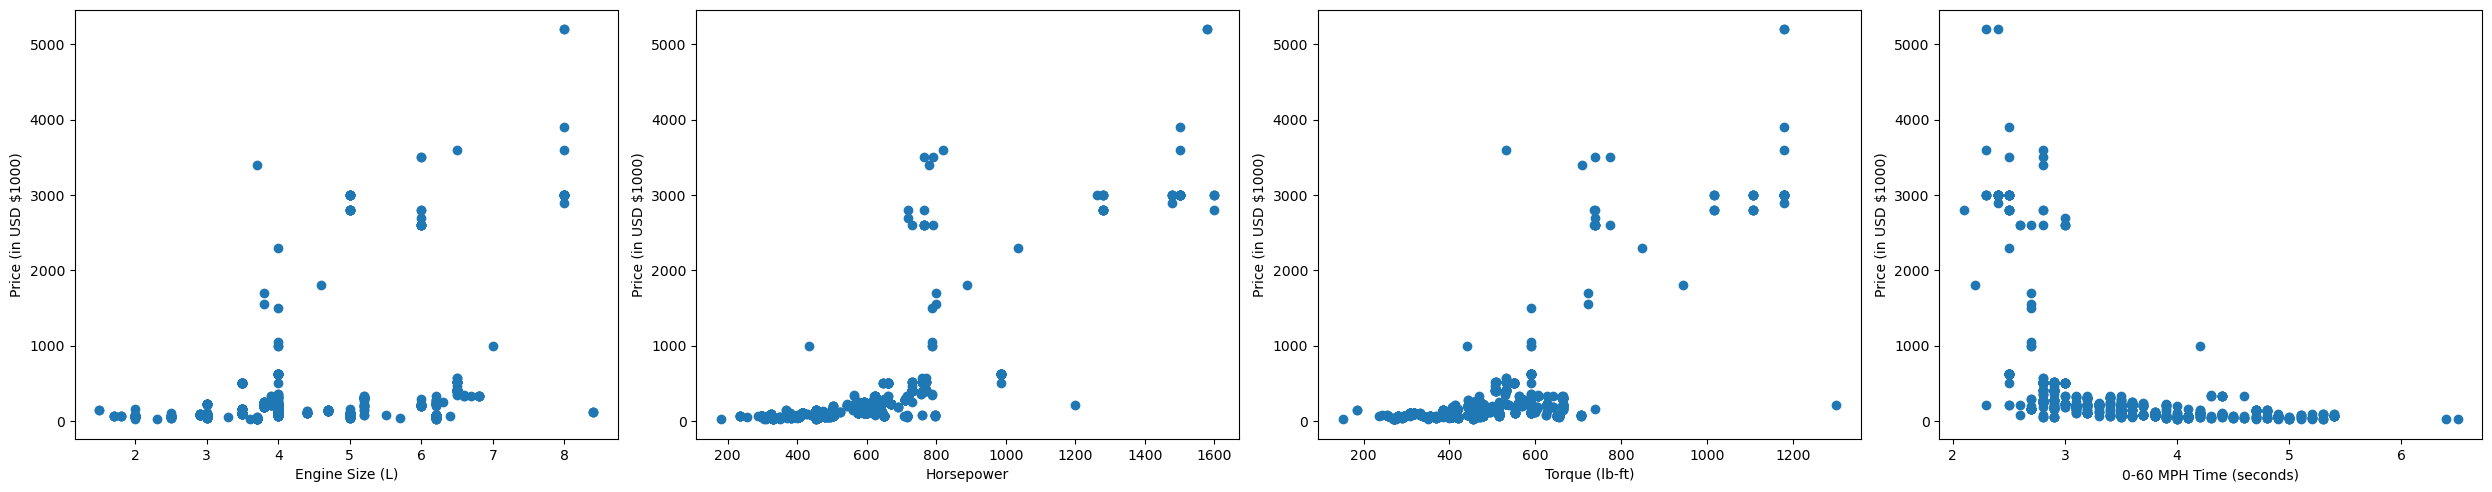

In [16]:
y = df['Price (in USD $1000)']
fig, ax = plt.subplots(1,4, figsize = (25,5))
ax[0].scatter(df['Engine Size (L)'], y)
ax[0].set_xlabel('Engine Size (L)')
ax[0].set_ylabel('Price (in USD $1000)')
ax[1].scatter(df['Horsepower'], y)
ax[1].set_xlabel('Horsepower')
ax[1].set_ylabel('Price (in USD $1000)')
ax[2].scatter(df['Torque (lb-ft)'], y)
ax[2].set_xlabel('Torque (lb-ft)')
ax[2].set_ylabel('Price (in USD $1000)')
ax[3].scatter(df['0-60 MPH Time (seconds)'], y)
ax[3].set_xlabel('0-60 MPH Time (seconds)')
ax[3].set_ylabel('Price (in USD $1000)')
fig.tight_layout(pad=1)
plt.show()